This notebook has code that goes into the official in Street Fighter 6 website to collect data on the number of players in each corresponding ranks. It then creates 2 visulizations to show the rank distribution.  
  
This program specifically logs in to the SF6 website. Selenium is used instead of BeautifulSoup since I was unable to fill out the necessary forms when entering the website without cookies (Brings the user to an age check and login screen).

<hr>  
  
# Gathering Data

In [ ]:
# Import libraries needed to webscrape
from selenium import webdriver # selects the web browser driver
from selenium.webdriver.common.by import By # enables element locators
from selenium.webdriver.support.select import Select # enables selection of "select" elements
from selenium.webdriver.support.wait import WebDriverWait # enables explicit waits
from selenium.common import NoSuchElementException, ElementNotInteractableException, StaleElementReferenceException # access to selenium errors to use for explicit waits

In [ ]:
# Code to webscrape and collect information

# Create a webdriver object to access the website with Google Chrome
driver = webdriver.Chrome()
driver.get("https://www.streetfighter.com/6/buckler/ranking/league")


homepage_log_in_button = driver.find_element(By.LINK_TEXT, "Log in/Sign up")
homepage_log_in_button.click()


# Create a variable of exempt errors to use when setting explicit waits
exempt_errors = [NoSuchElementException, ElementNotInteractableException, StaleElementReferenceException]
wait = WebDriverWait(driver, timeout = 3, poll_frequency = .2, ignored_exceptions = exempt_errors)


# Wait for the "country" dropdown element to be displayed to ensure the "age check" page loaded completely first
wait.until(lambda _: (driver.find_element(By.ID, "country")).is_displayed())


# Complete the age check form
country_dd = driver.find_element(By.ID, "country")
country_dd_select = Select(country_dd)
country_dd_select.select_by_value("US")

month_dd = driver.find_element(By.ID, "birthMonth")
month_dd_select = Select(month_dd)
month_dd_select.select_by_value("1")

day_dd = driver.find_element(By.ID, "birthDay")
day_dd_select = Select(day_dd)
day_dd_select.select_by_value("1")

year_dd = driver.find_element(By.ID, "birthYear")
year_dd_select = Select(year_dd)
year_dd_select.select_by_value("2000")

submit_button = driver.find_element(By.NAME, "submit")
submit_button.click()


# Wait for expected element to be displayed
wait.until(lambda _: (driver.find_element(By.NAME, "email")).is_displayed())


# Read log in credentials from a separate file in the same folder in order to make sure the credentials are separate from the code itself
credentials_file = "C:\\Users\\Binaryxx Sune\\Documents\\Programming\\personal_projects\\sf6_rank_dist\\capcom_cred.txt"
with open(credentials_file) as log_in_credentials:
    email, password = log_in_credentials.readlines()

email_textbox = driver.find_element(By.NAME, "email")
email_textbox.send_keys(email)

password_textbox = driver.find_element(By.NAME, "password")
password_textbox.send_keys(password)

submit_login_button = driver.find_element(By.NAME, "submit")
submit_login_button.click()


# Wait for total player count element to be displayed to make sure that the player rankings page has completely loaded
wait.until(lambda _: (driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM")).is_displayed())




# Prep Work: 
# When opening the website for the first time of the day; a pop up appears that prevents other elements to be displayed
# Decline cookies to be able to click on the filter button 
# store the total player population with no filters applied as a reference to use to confirm the page has completely loaded by checking if the value changes for explicit place
# apply the "North America" filter
try:
    (driver.find_element(By.CLASS_NAME, "praise_close_btn__sXC7W")).click()

except NoSuchElementException:
    (driver.find_element(By.ID, "CybotCookiebotDialogBodyButtonDecline")).click()
    last_player_count = driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM").text
    Select(driver.find_elements(By.CSS_SELECTOR, "select")[2]).select_by_value("5")


# Create a list called "ranks" to store all values webscraped from the webpage 
# (Not really necessary to iterate, but it's good to practice automating tasks such as typing in names with a repeating pattern of up to a 100 e.g. Rookie 1 to Rookie 100)
rank_groups = ["Rookie", "Iron", "Bronze", "Silver", "Gold", "Plutinum", "Diamond"]
ranks = ["All"]
rank_population = {}

for rank in rank_groups:
    for rank_tier in range(1,6):
        ranks.append(rank + " " + str(rank_tier))

ranks.append("Master") # Append "Master" in the end since it only has 1 tier i.e. no numbers after the rank name

for rank in ranks: # Fill in the rank_population dictionary with keys and empty values to eventually populate with the webscraped information
    rank_population[rank] = None


# Iterate through all ranks and check for the total playerbase
for i in range(37):
    Select(driver.find_elements(By.CSS_SELECTOR, "select")[0]).select_by_value(str(i))
    (driver.find_element(By.CLASS_NAME, "ranking_search_search__btn__2iLM8")).click()
    
    wait.until(lambda _: driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM").text != last_player_count)

    rank_population[ranks[i]] = (driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM").text)[2:]
    last_player_count = driver.find_element(By.CLASS_NAME, "ranking_ranking_now__last__TghLM").text

<hr>  
  
# Visualizing the Data

In [ ]:
# Import libraries for data visualization
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from datetime import date

### Dataframe of the Ranks and their Player Count

In [ ]:
# Create a dataframe to use for visualization
rank_df = pd.DataFrame([rank_population.keys(), rank_population.values()])

rank_df = rank_df.transpose()
rank_df = rank_df.rename(columns = {0:"Rank",1:"Population"})
rank_df = rank_df.astype({"Population":"int32"})

adj_rank_df = rank_df.drop([0])
adj_rank_df = adj_rank_df.reset_index(drop=True)

adj_rank_df

### Bar Graph of the Player Count in Each Rank in North America

In [ ]:
# Create a dictionary with the rgba values 
rank_colors = {"Rookie": (0.95,0.95,0.95,1), "Iron": (0.6,0.6,0.55,1), "Bronze": (0.6,0.45,0.3,1), "Silver": (0.7,0.75,0.75,1), 
               "Gold": (0.9,0.8,0.5,1), "Plutinum": (0.25,0.6,0.65,1), "Diamond": (0.75,0.2,0.5,1), "Master": (0.3,0.8,0.6,1)}

# Create a function to assign each rank groups their corresponding rgba values found in the dictionary
def group_ranks(rank):

    rank_group = rank.split()[0]
    return rank_colors[rank_group]

rank_group_color = (adj_rank_df["Rank"].apply(group_ranks)).values.tolist()
rank_palette = []

for rank in range(7):

    for tier in range(5):
        rgba_tuple = []

        for rgba_idx in range(4):
            original_rgba_list = list(rank_colors.values())[rank][rgba_idx]
            
            if rgba_idx == 3:
                rgba_tuple.append(round(original_rgba_list))
            else:
                rgba_tuple.append(round(original_rgba_list - tier/20, 2))

        rank_palette.append(tuple(rgba_tuple))
rank_palette.append(rank_colors["Master"]) # Master Rank Color

# Calculate the max y value and use it as a basis to get the right intervals to use for y ticks max value; np.linspace has a very uneven interval which I do not like
rounded_max_total_player_count = round(adj_rank_df["Population"].max(), -3)
total_y_ticks_interval_number = 25
total_y_ticks_intervals = int(round(rounded_max_total_player_count / total_y_ticks_interval_number, -3))


# Plot the data as a bar graph
fig, ax = plt.subplots()

ax = adj_rank_df.plot(kind = "bar", 
                      x = "Rank", 
                      y = "Population", 
                      yticks = range(0, rounded_max_total_player_count + total_y_ticks_intervals, total_y_ticks_intervals), 
                      title = "Street Fighter 6 Rank Distribution as of " + (date.today()).strftime("%m/%d/%y"), 
                      color = rank_palette, 
                      edgecolor = (0.25,0.25,0.25,0.75), 
                      grid = True, 
                      legend = False) 

ax.set_axisbelow(True)
ax.grid(axis = "x")
fig.set_size_inches(12,12)

plt.xlabel("Ranks")
plt.ylabel("Population")


plt.show()

### Stacked Bar Graph of the Total Player Count in Each Rank Groups

In [ ]:
# Create a new dataframe for which tier of ranks e.g. Rookie 1, Bronze 1, Rookie 1, etc. into one df
tier1_df = adj_rank_df[(adj_rank_df["Rank"].str[-1] == "1")]
tier1_df.loc[99] = adj_rank_df[(adj_rank_df["Rank"] == "Master")].values.tolist()[0]
tier1_df = tier1_df.reset_index(drop=True)

tier2_df = adj_rank_df[(adj_rank_df["Rank"].str[-1] == "2")]
tier2_df.loc[99] = ["Master", 0]
tier2_df = tier2_df.reset_index(drop=True)

tier3_df = adj_rank_df[(adj_rank_df["Rank"].str[-1] == "3")]
tier3_df.loc[99] = ["Master", 0]
tier3_df = tier3_df.reset_index(drop=True)

tier_4_df = adj_rank_df[(adj_rank_df["Rank"].str[-1] == "4")]
tier_4_df.loc[99] = ["Master", 0]
tier_4_df = tier_4_df.reset_index(drop=True)

tier5_df = adj_rank_df[(adj_rank_df["Rank"].str[-1] == "5")]
tier5_df.loc[99] = ["Master", 0]
tier5_df = tier5_df.reset_index(drop=True)

rank_tiers = [tier1_df, tier2_df, tier3_df, tier_4_df, tier5_df]


# Prepwork for plotting the graph
fig, ax = plt.subplots()

tier_starting_bottom_height = np.zeros(8)
x_ticks_labels = ("Rookie", "Iron", "Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master")

# Create new rgba values
tier1_palette, tier2_palette, tier3_palette, tier4_palette, tier5_palette = ([] for _ in range(5))
stacked_bar_palettes = [tier1_palette, tier2_palette, tier3_palette, tier4_palette, tier5_palette]

for tier in range(5):

    for rank in range(8):
        rgba_tuple = []

        for rgba_idx in range(4):
            original_rgba_list = list(rank_colors.values())[rank][rgba_idx]
            
            if rgba_idx == 3:
                rgba_tuple.append(round(original_rgba_list))
            else:
                rgba_tuple.append(round(original_rgba_list - tier/20, 2))

        stacked_bar_palettes[tier].append(tuple(rgba_tuple))


# Plot the bar graph for each tier, plotting the bar where the previous tier left off to stack the bars of the same rank group together
for idx, group in enumerate(rank_tiers):
    group.plot(kind = "bar",
               ax = ax,
               x = "Rank", 
               y = "Population",
               bottom = tier_starting_bottom_height,
               title = "Street Fighter 6 Rank Distribution as of " + (date.today()).strftime("%m/%d/%y"), 
               color = stacked_bar_palettes[idx],
               edgecolor = (0.25,0.25,0.25,0.75),
               legend = False,
               grid = True)

    tier_starting_bottom_height += rank_tiers[idx]["Population"].values # update the starting height so that the next tier starts where the previous tier ends

tier_y_ticks_interval_number = 25
tier_max_y_tick = int(np.max(tier_starting_bottom_height))
tier_y_ticks_intervals = int(round(tier_max_y_tick / tier_y_ticks_interval_number, -3))

ax.set_yticks(range(0, tier_max_y_tick + tier_y_ticks_intervals, tier_y_ticks_intervals))
ax.set_xticklabels(x_ticks_labels, rotation='vertical')
ax.set_axisbelow(True)
ax.grid(axis = "x")
fig.set_size_inches(12,12)

plt.xlabel("Ranks")
plt.ylabel("Population")


plt.show()

### Cumulative Percentile of Each Rank

In [164]:
# Create a new dataframe with the percentiles for each respective rank
rank_population_sum = sum(list(adj_rank_df["Population"].values))
rank_population_list = list(adj_rank_df["Population"].values)
rank_list = list(adj_rank_df["Rank"].values)
for idx, x in enumerate(range(25,30)):
    rank_list[x] = "Platinum " + str(idx+1)

def percentile_calculator(population):
    percentile = round((population / rank_population_sum)*100, 2)
    return percentile

rank_percentile_list = adj_rank_df["Population"].apply(percentile_calculator)
rank_cumulative_percentile_list = round(rank_percentile_list.cumsum(),1)
rank_percentile_df = pd.DataFrame([rank_list, rank_cumulative_percentile_list],).transpose()
rank_percentile_df = rank_percentile_df.rename({0:"Rank", 1:"Cumulative Percentile"}, axis = 1)

rank_percentile_df

,Rank,Cumulative Percentile
0,Rookie 1,3.1
1,Rookie 2,4.3
2,Rookie 3,5.5
3,Rookie 4,6.6
4,Rookie 5,7.6
5,Iron 1,12.3
6,Iron 2,14.9
7,Iron 3,17.6
8,Iron 4,20.0
9,Iron 5,21.5


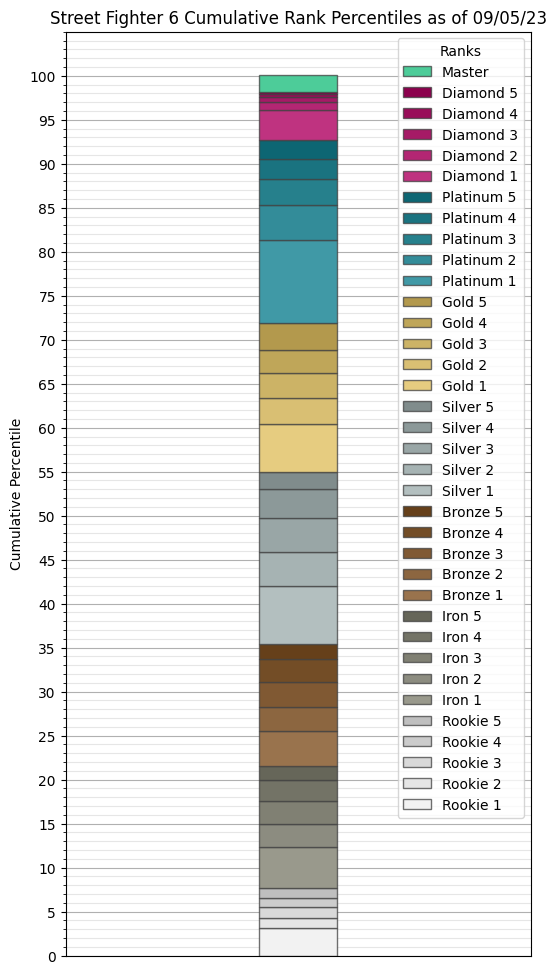

In [165]:
# Plot the Cumulative Rank Percentiles with One Stacked Bar
fig, ax = plt.subplots()
percentile_starting_bottom_height = 0

for i in range(36):
    percentile_df = pd.DataFrame([rank_list[idx], rank_percentile_list[i]]).transpose()
    percentile_df.plot(kind = "bar",
                       ax = ax,
                       yticks = range(0,101,5), 
                       width = 0.1,
                       bottom = percentile_starting_bottom_height,
                       title = "Street Fighter 6 Cumulative Rank Percentiles as of " + (date.today()).strftime("%m/%d/%y"), 
                       color = rank_palette[i],
                       edgecolor = (0.25,0.25,0.25,0.75),
                       grid = True)
    percentile_starting_bottom_height += rank_percentile_list[i]

ax.set_axisbelow(True)
ax.grid(axis = "x")
ax.grid(which = "minor", color = (0.9,0.9,0.9))
ax.minorticks_on()

handles, _ = ax.get_legend_handles_labels()
labels = rank_list
ax.legend(handles[::-1], labels[::-1], title = "Ranks")

fig.set_size_inches(6,12)

plt.tick_params(bottom = False, labelbottom = False)
plt.ylabel("Cumulative Percentile")


plt.show()